In [34]:
import os
import subprocess
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.functions import explode, col, count, from_unixtime, floor, date_format, hour, lower, when, round, udf
from pyspark.sql.types import *
from pyspark.sql.functions import sum as spark_sum
from functools import reduce
from pyspark.ml.feature import Tokenizer, HashingTF

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
gcs_folder = 'gs://msca-bdp-data-open/final_project_git'

## Data Cleaning Functions

In [5]:
def null_count(df):
    return df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) 
     for c in df.columns
    ]).show(truncate=False)

In [6]:
def show_duplicates(df):
    df.groupBy(*df.columns) \
    .agg(count("*").alias("duplicate_count")) \
    .filter(col("duplicate_count") > 1) \
    .show(truncate=False)

# Commit Data

In [7]:
df_commits = spark.read.parquet(os.path.join(gcs_folder, 'commits'))
print(f'Records read from dataframe *commits*: {df_commits.count():,.0f}')
df_commits.printSchema()

Records read from dataframe *commits*: 265,419,190
root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (n

In [8]:
sample_df_commits = df_commits.sample(fraction = 0.01, seed = 42)
sample_df_commits.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------+
|              commit|                tree|              parent|              author|           committer|             subject|             message|trailer|          difference|difference_truncated|           repo_name|encoding|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------+
|c55f629032ca5c180...|e0329d5c46f3e3de0...|[deefff499e9ca057...|{saiya_mg, 2038cc...|{saiya_mg, 2038cc...|                    |                    |     []|                  []|                NULL|[UltraStar-Deluxe...|    NULL|
|25c21b002dfe56b05...|057444063ef534bed...|[f6b0e3072e1faea4...|{fgonzalez, 0e3ef...

In [9]:
# Select and clean relevant columns from the commits DataFrame
df_commits_cleaned = sample_df_commits.select(
    col("commit"),
    col("tree"),
    col("parent"),
    
    # Extract author details
    col("author.name").alias("author_name"),
    col("author.email").alias("author_email"),
    from_unixtime(col("author.time_sec")).alias("author_time"), 
    
    # Extract committer details
    col("committer.name").alias("committer_name"),
    col("committer.email").alias("committer_email"),
    from_unixtime(col("committer.time_sec")).alias("committer_time"),
    
    # Commit metadata
    col("subject"),
    col("message"),
    
    # Extract first element from 'repo_name' array
    col("repo_name")[0].alias("repo_name")
)

df_commits_cleaned.show(5)

+--------------------+--------------------+--------------------+------------+--------------------+-------------------+--------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|              commit|                tree|              parent| author_name|        author_email|        author_time|committer_name|     committer_email|     committer_time|             subject|             message|           repo_name|
+--------------------+--------------------+--------------------+------------+--------------------+-------------------+--------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|c55f629032ca5c180...|e0329d5c46f3e3de0...|[deefff499e9ca057...|    saiya_mg|2038cc10d6ba154f1...|2008-11-06 20:12:31|      saiya_mg|2038cc10d6ba154f1...|2008-11-06 20:12:31|                    |                    |UltraStar-Deluxe/...|
|25c21b002dfe56b05...|057444063ef534bed...|[f6b0

In [10]:
null_count(df_commits_cleaned)

+------+----+------+-----------+------------+-----------+--------------+---------------+--------------+-------+-------+---------+
|commit|tree|parent|author_name|author_email|author_time|committer_name|committer_email|committer_time|subject|message|repo_name|
+------+----+------+-----------+------------+-----------+--------------+---------------+--------------+-------+-------+---------+
|0     |0   |0     |0          |0           |0          |0             |0              |0             |0      |0      |0        |
+------+----+------+-----------+------------+-----------+--------------+---------------+--------------+-------+-------+---------+



In [11]:
show_duplicates(df_commits_cleaned)

+------+----+------+-----------+------------+-----------+--------------+---------------+--------------+-------+-------+---------+---------------+
|commit|tree|parent|author_name|author_email|author_time|committer_name|committer_email|committer_time|subject|message|repo_name|duplicate_count|
+------+----+------+-----------+------------+-----------+--------------+---------------+--------------+-------+-------+---------+---------------+
+------+----+------+-----------+------------+-----------+--------------+---------------+--------------+-------+-------+---------+---------------+



In [12]:
df_commits_cleaned.describe().show()

25/03/16 01:10:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+-----------+------------+-------------------+--------------------+---------------+-------------------+--------------+----------------+--------------------+
|summary|              commit|                tree|author_name|author_email|        author_time|      committer_name|committer_email|     committer_time|       subject|         message|           repo_name|
+-------+--------------------+--------------------+-----------+------------+-------------------+--------------------+---------------+-------------------+--------------+----------------+--------------------+
|  count|             2653047|             2653047|    2653047|     2653047|            2653047|             2653047|        2653047|            2653047|       2653047|         2653047|             2653047|
|   mean|                NULL|                NULL|        NaN|         NaN|               NULL|                 NaN|            NaN|               NULL|      Infinity|    

In [13]:
# Count the number of distinct repositories
distinct_repo_count = df_commits_cleaned.select("repo_name").distinct().count()
print(f"Total distinct repositories: {distinct_repo_count}")

Total distinct repositories: 697525


#### Author Analysis

In [14]:
# Count the number of commits per year based on the author's timestamp
df_commits_cleaned \
    .withColumn("year", col("author_time").substr(1, 4)) \
    .groupBy("year") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+----+------+
|year| count|
+----+------+
|2016|380544|
|2017|378537|
|2015|362415|
|2014|275264|
|2018|185921|
|2013|182079|
|2019|130230|
|2012|118316|
|2020|115821|
|2021| 90392|
|2011| 85777|
|2010| 68434|
|2022| 60526|
|2009| 53237|
|2008| 38567|
|2007| 29081|
|2006| 22011|
|2005| 17459|
|2003| 16438|
|2004| 14154|
+----+------+
only showing top 20 rows



In [15]:
# Extract years from author_time
df_years = df_commits_cleaned.withColumn("year", col("author_time").substr(1, 4).cast("int"))

# Calculate first year, and last year
first_year = df_years.selectExpr("min(year)").collect()[0][0]
last_year = df_years.selectExpr("max(year)").collect()[0][0]

print(f"First year: {first_year}")
print(f"Last year: {last_year}")

Total unique years: 70
First year: 1970
Last year: 2050


Since the number of years so huge I have decided to use 5-year intervals to represent the data

### 5-year intervals for number of commits based on the author's timestamp

In [16]:
# Calculate 5-year intervals and count commits
interval_count_pd = df_commits_cleaned.withColumn("year_int", col("author_time").substr(1, 4).cast("int")) \
    .withColumn("year_interval", (floor(col("year_int") / 5) * 5).cast("int")) \
    .groupBy("year_interval").count().orderBy("year_interval").toPandas()

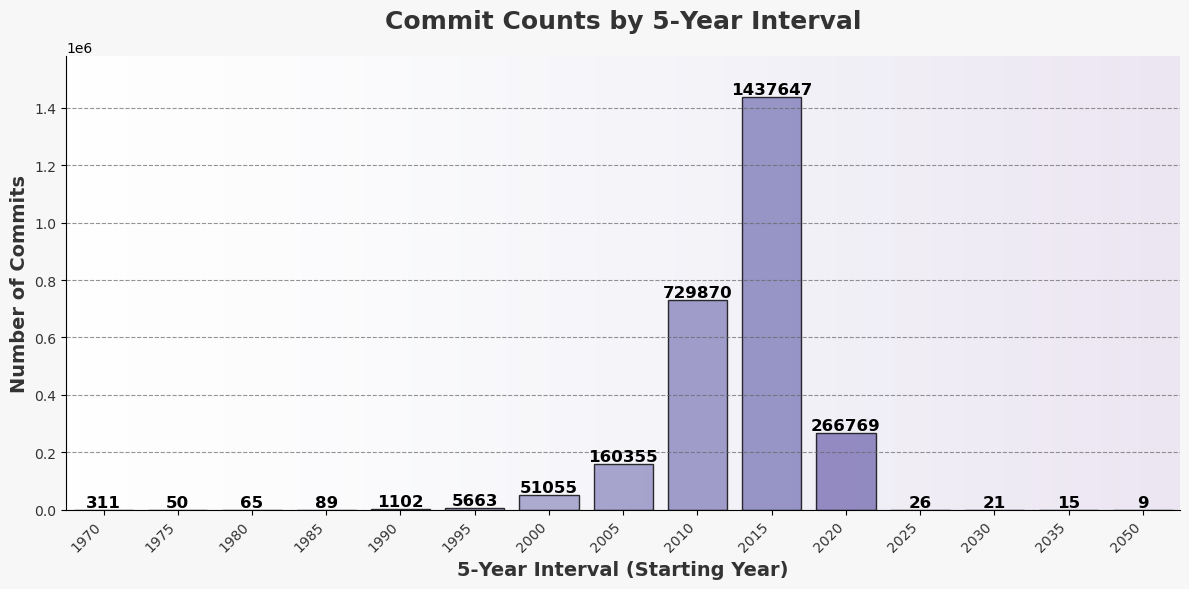

In [17]:
# Step 1: Plot the commit counts by 5-year interval with a modern design
plt.figure(figsize=(12, 6), facecolor="#f7f7f7")  # Light gray background

# Add a gradient background
ax = plt.gca()
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Purples", alpha=0.1, extent=(-0.5, len(interval_count_pd) - 0.5, 0, interval_count_pd["count"].max() * 1.1))

# Create a gradient color palette for the bars using the Greens colormap
colors = plt.cm.Purples(np.linspace(0.3, 0.8, len(interval_count_pd)))  # Greens colormap

# Customize the bar plot
bars = plt.bar(interval_count_pd['year_interval'].astype(str), interval_count_pd['count'], color=colors, edgecolor="black", alpha=0.8)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}", ha="center", va="bottom", fontsize=12, color="black", fontweight="bold")

# Add title and labels
plt.title("Commit Counts by 5‑Year Interval", fontsize=18, pad=20, color="#333333", fontweight="bold")
plt.xlabel("5‑Year Interval (Starting Year)", fontsize=14, color="#333333", fontweight="bold")
plt.ylabel("Number of Commits", fontsize=14, color="#333333", fontweight="bold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", color="#333333")
plt.yticks(color="#333333")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7, color="#666666")

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

- The time interval spans for 70 years from 1970 to 2050 and so we are goin to clean it. 
- The time interval that I have picked is from 2005, Git's release, until the end of 2025, current year.

In [18]:
# Filter commits between 2005-01-01 and 2025-12-31
unfiltered_count = df_commits_cleaned.count()
df_commits_cleaned = df_commits_cleaned.filter((col("author_time") >= "2005-01-01") & (col("author_time") <= "2025-12-31"))
filtered_count = df_commits_cleaned.count()

print(f"Commits before filtering: {unfiltered_count}")
print(f"Commits after filtering:  {filtered_count}")
print(f"Removed outliers:         {unfiltered_count - filtered_count}")

Commits before filtering: 2653047
Commits after filtering:  2594644
Removed outliers:         58403


### Commits by months of the year

Commits by Month:


+-----+------+
|month| count|
+-----+------+
|  Mar|235939|
|  Oct|232787|
|  May|223741|
|  Apr|219443|
|  Jan|216154|
|  Aug|214466|
|  Sep|213724|
|  Nov|212504|
|  Feb|212343|
|  Jun|210085|
|  Jul|209800|
|  Dec|193658|
+-----+------+



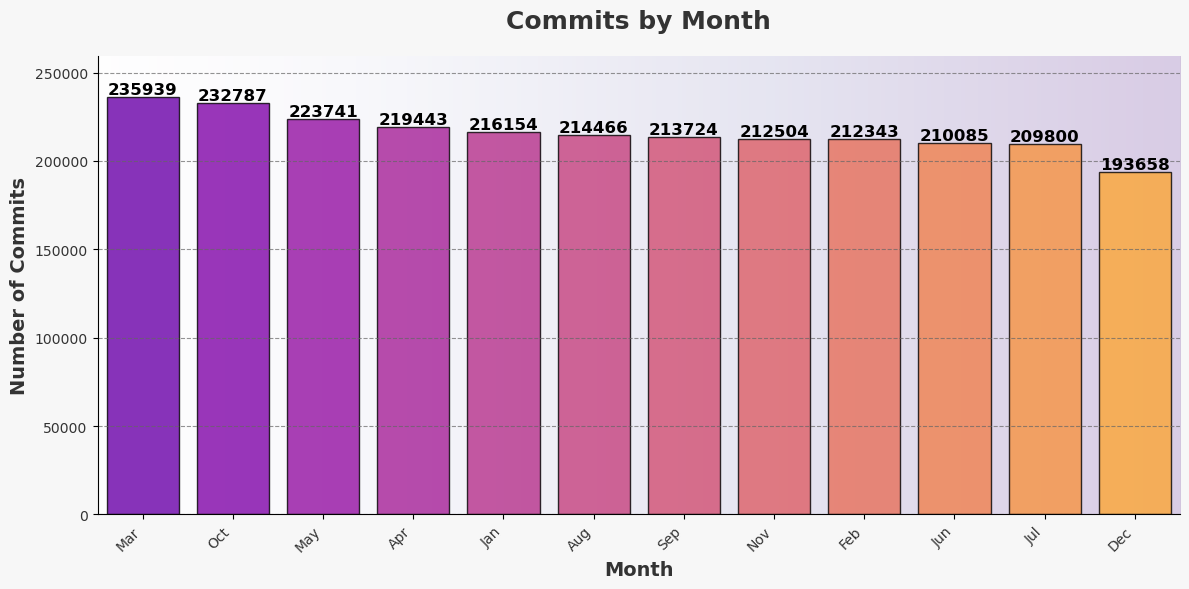

In [19]:
# Step 1: Create a new column for the month (e.g., Jan, Feb, Mar, etc.)
df_month = df_commits_cleaned.withColumn("month", date_format("author_time", "MMM"))

# Step 2: Group by month and count the number of commits per month
df_counts_month = (
    df_month.groupBy("month")
    .count()
    .orderBy("count", ascending=False)
)

# Step 3: Display the counts
print("Commits by Month:")
df_counts_month.show()

# Step 4: Convert the result to a Pandas DataFrame for plotting
counts_month_pd = df_counts_month.toPandas()

# Step 5: Plot the monthly commit counts with a modern design
plt.figure(figsize=(12, 6), facecolor="#f7f7f7")  # Light gray background

# Add a gradient background
ax = plt.gca()
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Purples", alpha=0.2, extent=(-0.5, len(counts_month_pd) - 0.5, 0, counts_month_pd["count"].max() * 1.1))

# Create a gradient color palette for the bars using the plasma colormap
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(counts_month_pd)))  # Plasma colormap

# Customize the bar plot
bars = plt.bar(counts_month_pd["month"], counts_month_pd["count"], color=colors, edgecolor="black", alpha=0.8)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}", ha="center", va="bottom", fontsize=12, color="black", fontweight="bold")

# Add title and labels
plt.title("Commits by Month", fontsize=18, pad=20, color="#333333", fontweight="bold")
plt.xlabel("Month", fontsize=14, color="#333333", fontweight="bold")
plt.ylabel("Number of Commits", fontsize=14, color="#333333", fontweight="bold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", color="#333333")
plt.yticks(color="#333333")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7, color="#666666")

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

### Commits by days of the week

Commits by Day of Week:


+-----------+------+
|day_of_week| count|
+-----------+------+
|        Tue|434009|
|        Wed|430769|
|        Thu|421785|
|        Mon|407023|
|        Fri|397004|
|        Sun|255902|
|        Sat|248152|
+-----------+------+



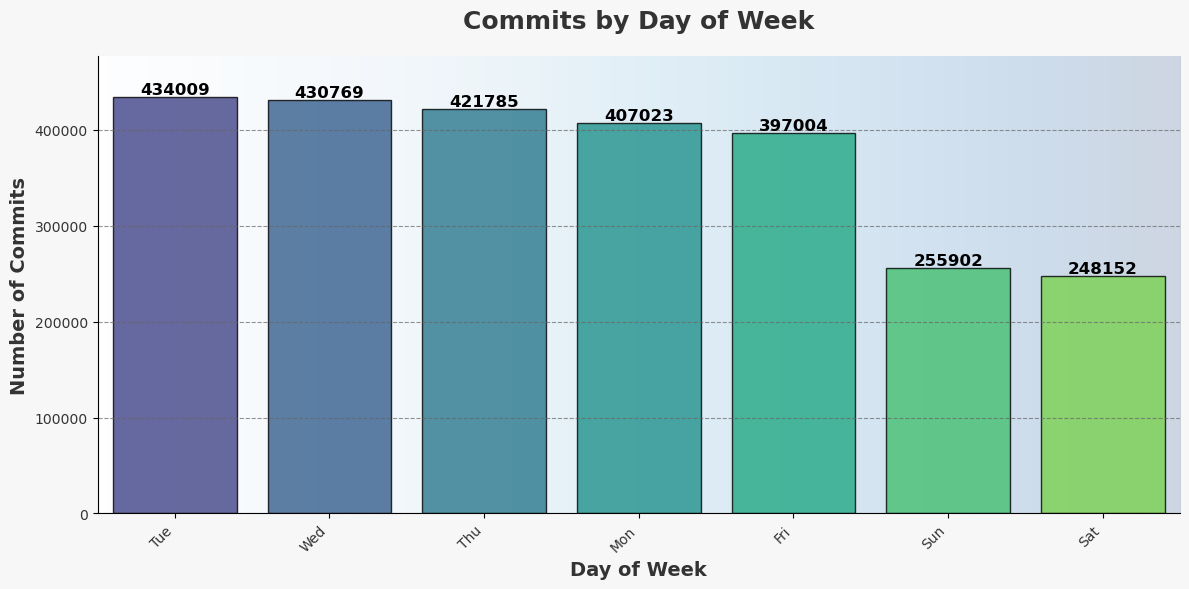

In [20]:
# Step 1: Create a new column for the day of the week (e.g., Mon, Tue, Wed, etc.)
df_day = df_commits_cleaned.withColumn("day_of_week", date_format("author_time", "E"))

# Step 2: Group by day_of_week and count the number of commits per day
df_counts_day = (
    df_day.groupBy("day_of_week")
    .count()
    .orderBy("count", ascending=False)
)

# Step 3: Display the counts
print("Commits by Day of Week:")
df_counts_day.show()

# Step 4: Convert the result to a Pandas DataFrame for plotting
counts_day_pd = df_counts_day.toPandas()

# Step 5: Plot the daily commit counts with a modern design
plt.figure(figsize=(12, 6), facecolor="#f7f7f7")  # Light gray background

# Add a gradient background
ax = plt.gca()
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Blues", alpha=0.2, extent=(-0.5, len(counts_day_pd) - 0.5, 0, counts_day_pd["count"].max() * 1.1))

# Create a gradient color palette for the bars
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(counts_day_pd)))  # Viridis colormap

# Customize the bar plot
bars = plt.bar(counts_day_pd["day_of_week"], counts_day_pd["count"], color=colors, edgecolor="black", alpha=0.8)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}", ha="center", va="bottom", fontsize=12, color="black", fontweight="bold")

# Add title and labels
plt.title("Commits by Day of Week", fontsize=18, pad=20, color="#333333", fontweight="bold")
plt.xlabel("Day of Week", fontsize=14, color="#333333", fontweight="bold")
plt.ylabel("Number of Commits", fontsize=14, color="#333333", fontweight="bold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", color="#333333")
plt.yticks(color="#333333")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7, color="#666666")

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

### Commits by hours per day

Commits by Hour of Day:


+-----------+------+
|commit_hour| count|
+-----------+------+
|          0| 84555|
|          1| 75075|
|          2| 71041|
|          3| 68291|
|          4| 64756|
|          5| 64620|
|          6| 72046|
|          7| 83175|
|          8| 97332|
|          9|109489|
|         10|108390|
|         11|107191|
|         12|117474|
|         13|133014|
|         14|147784|
|         15|152055|
|         16|144885|
|         17|136643|
|         18|133802|
|         19|134161|
+-----------+------+
only showing top 20 rows



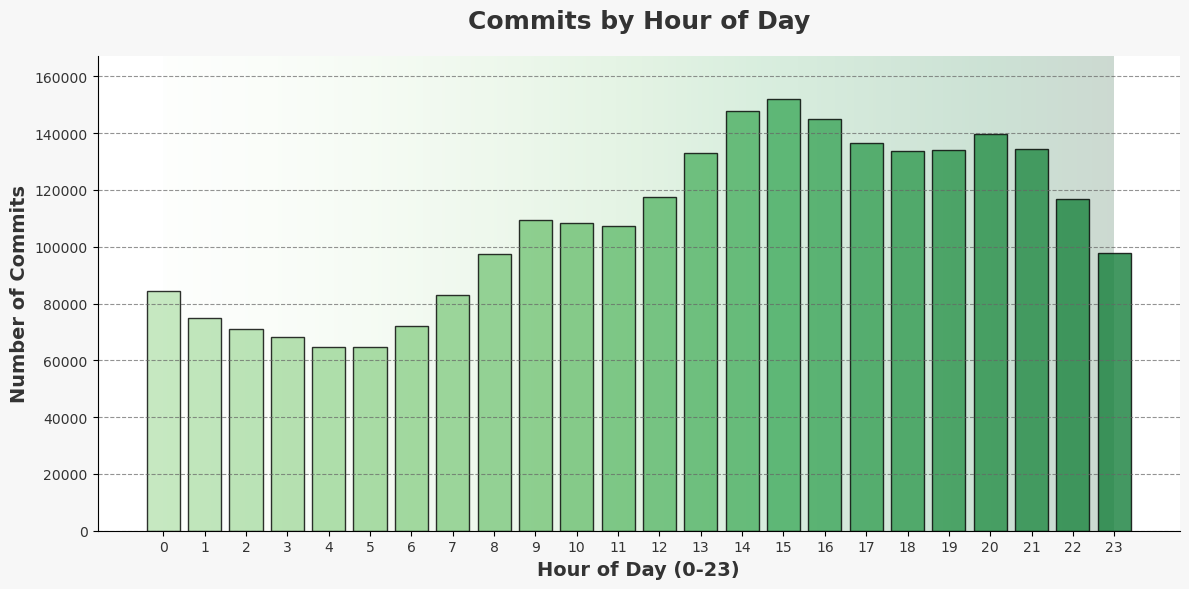

In [21]:
# Step 1: Extract the hour (0-23) from author_time
df_hour = df_commits_cleaned.withColumn("commit_hour", hour("author_time"))

# Step 2: Group by the hour and count the number of commits for each hour
df_counts_hour = (
    df_hour.groupBy("commit_hour")
    .count()
    .orderBy("commit_hour")
)

# Step 3: Display the counts
print("Commits by Hour of Day:")
df_counts_hour.show()

# Step 4: Convert the result to a Pandas DataFrame for plotting
counts_hour_pd = df_counts_hour.toPandas()

# Step 5: Plot the hourly commit counts with a modern design
plt.figure(figsize=(12, 6), facecolor="#f7f7f7")  # Light gray background

# Add a gradient background
ax = plt.gca()
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Greens", alpha=0.2, extent=(0, 23, 0, counts_hour_pd["count"].max() * 1.1))

# Create a gradient color palette for the bars using the Greens colormap
colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(counts_hour_pd)))  # Greens colormap

# Customize the bar plot
bars = plt.bar(counts_hour_pd["commit_hour"], counts_hour_pd["count"], color=colors, edgecolor="black", alpha=0.8)

# Add title and labels
plt.title("Commits by Hour of Day", fontsize=18, pad=20, color="#333333", fontweight="bold")
plt.xlabel("Hour of Day (0-23)", fontsize=14, color="#333333", fontweight="bold")
plt.ylabel("Number of Commits", fontsize=14, color="#333333", fontweight="bold")

# Set x-axis ticks to show every hour
plt.xticks(range(0, 24), color="#333333")
plt.yticks(color="#333333")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7, color="#666666")

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

#### Committer Analysis

+--------------------+------+
|      committer_name| count|
+--------------------+------+
|              GitHub|215164|
|  Gerrit Code Review|  5892|
|        devs-mycroft|  5173|
|       Duane F. King|  4448|
|          Commit Bot|  4167|
|        Curt Clifton|  3825|
|James Michael DuPont|  3483|
|    CI Pool Resource|  3140|
|                root|  3112|
|                time|  2854|
|          miatribepi|  2803|
|Matthew Weier O'P...|  2746|
|             unknown|  2689|
|    Chromium LUCI CQ|  2335|
|          Commit bot|  2267|
|conda-forge-coord...|  2064|
|Gerrit - the frie...|  1965|
|Android Git Autom...|  1953|
|  Greg Kroah-Hartman|  1946|
|             Emile B|  1926|
+--------------------+------+
only showing top 20 rows



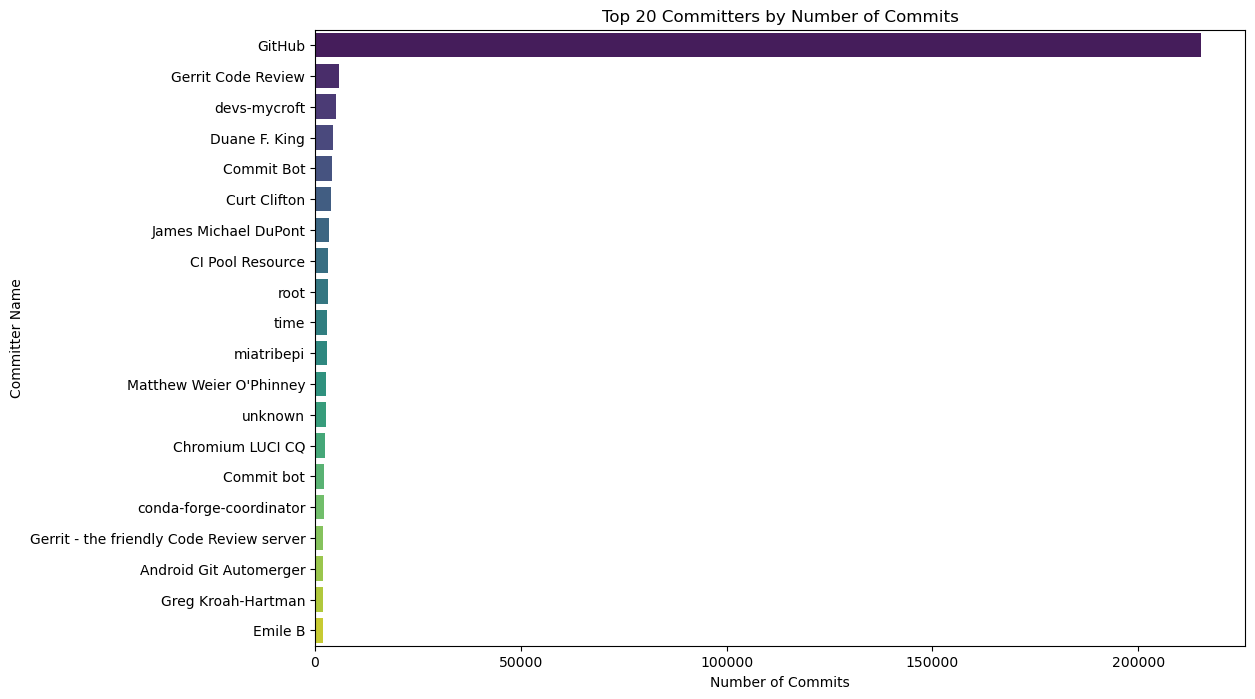

In [22]:
# Count the number of commits per year based on the author's timestamp
committers_count = (
    df_commits_cleaned
    .groupBy("committer_name")
    .count()
    .orderBy(F.col("count").desc())
)

# Show the committers in descending order
committers_count.show()

# Convert to Pandas DataFrame for further analysis or visualization
committers_count = committers_count.toPandas()

# Limit to top 20 committers for better readability
top_committers = committers_count.head(20)

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a bar plot for top 20 committers
sns.barplot(x='count', y='committer_name', data=top_committers, palette='viridis')

# Add labels and title
plt.xlabel('Number of Commits')
plt.ylabel('Committer Name')
plt.title('Top 20 Committers by Number of Commits')

# Show the plot
plt.show()

### Join Liscenses Data

In [23]:
df_licenses = spark.read.parquet(os.path.join(gcs_folder, 'licenses'))

print(f'Records read from dataframe *licenses*: {df_licenses.count():,.0f}')

df_licenses.printSchema()

sample_df_licenses = df_licenses.sample(fraction = 0.01, seed = 42)

sample_df_licenses.show(5)

licenses_commit_join = df_commits_cleaned.join(df_licenses, on="repo_name", how="inner")

Records read from dataframe *licenses*: 3,325,634
root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)



+--------------------+------------+
|           repo_name|     license|
+--------------------+------------+
|      Roseluck/AIRTS|artistic-2.0|
|capqueen/CapQueenCMS|artistic-2.0|
|adhikjoshi/bellev...|artistic-2.0|
|catalyst/Net-SSLe...|artistic-2.0|
|        raydiak/pray|artistic-2.0|
+--------------------+------------+
only showing top 5 rows



### Number of repositories by license

+------------+----------+------------+
|license     |repo_count|commit_count|
+------------+----------+------------+
|mit         |933982    |933982      |
|apache-2.0  |446539    |446539      |
|gpl-2.0     |357463    |357463      |
|gpl-3.0     |330453    |330453      |
|bsd-3-clause|177505    |177505      |
|agpl-3.0    |110842    |110842      |
|bsd-2-clause|53935     |53935       |
|lgpl-2.1    |48525     |48525       |
|lgpl-3.0    |42974     |42974       |
|mpl-2.0     |24970     |24970       |
|unlicense   |19937     |19937       |
|cc0-1.0     |14722     |14722       |
|epl-1.0     |14229     |14229       |
|isc         |12919     |12919       |
|artistic-2.0|5649      |5649        |
+------------+----------+------------+



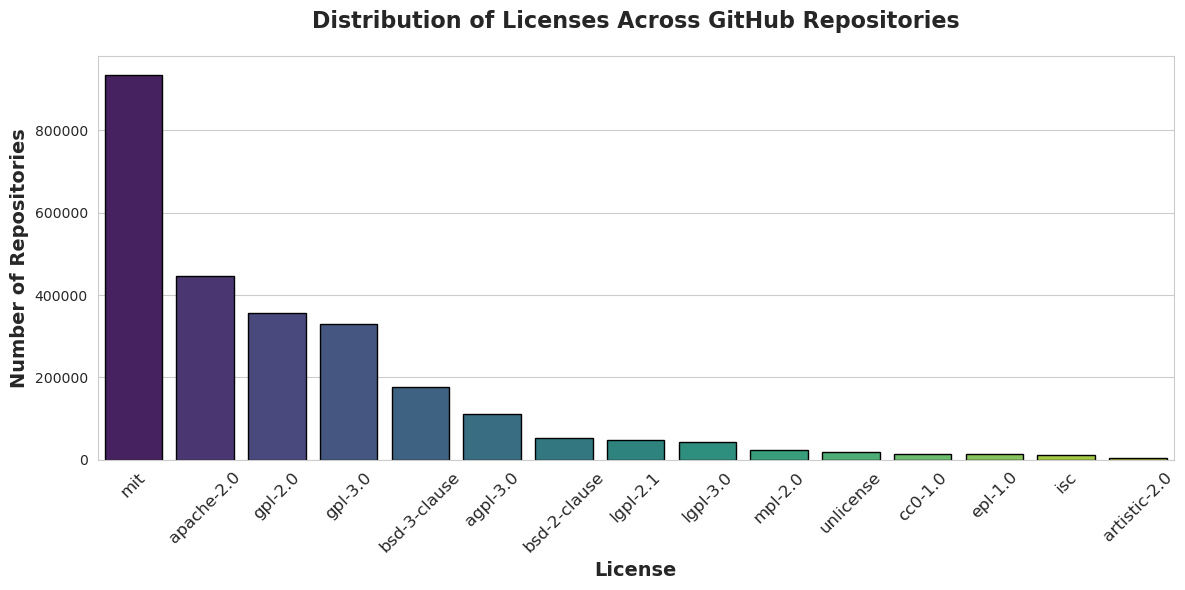

In [23]:
# Group by license and count repositories and commits
license_stats = licenses_commit_join.groupBy("license") \
    .agg(
        count("repo_name").alias("repo_count"),  # Count repositories
        count("*").alias("commit_count")         # Count commits
    ) \
    .orderBy("commit_count", ascending=False)

license_stats.show(truncate=False)

# Convert to Pandas for plotting
license_stats_pd = license_stats.toPandas()

# Plot the distribution of licenses by repository count
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x="license", y="repo_count", data=license_stats_pd, palette="viridis", edgecolor="black")
plt.xlabel("License", fontsize=14, fontweight="bold")
plt.ylabel("Number of Repositories", fontsize=14, fontweight="bold")
plt.title("Distribution of Licenses Across GitHub Repositories", fontsize=16, pad=20, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

### Analyzing big tech and technology mentions in commit messages  

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Technology Keyword Counts in Commit Messages:
kubernetes: 1298
docker: 8371
serverless: 91
cloud: 8369
microservices: 56
blockchain: 209
spark: 2006
hadoop: 595
iot: 1793
edge computing: 2
machine learning: 50
ai: 196456
deep learning: 17
big data: 35

Big Tech Keyword Counts in Commit Messages:
google: 24518
microsoft: 1838
amazon: 681
facebook: 1973
apple: 1780
ibm: 3570
oracle: 2339
linux: 23648


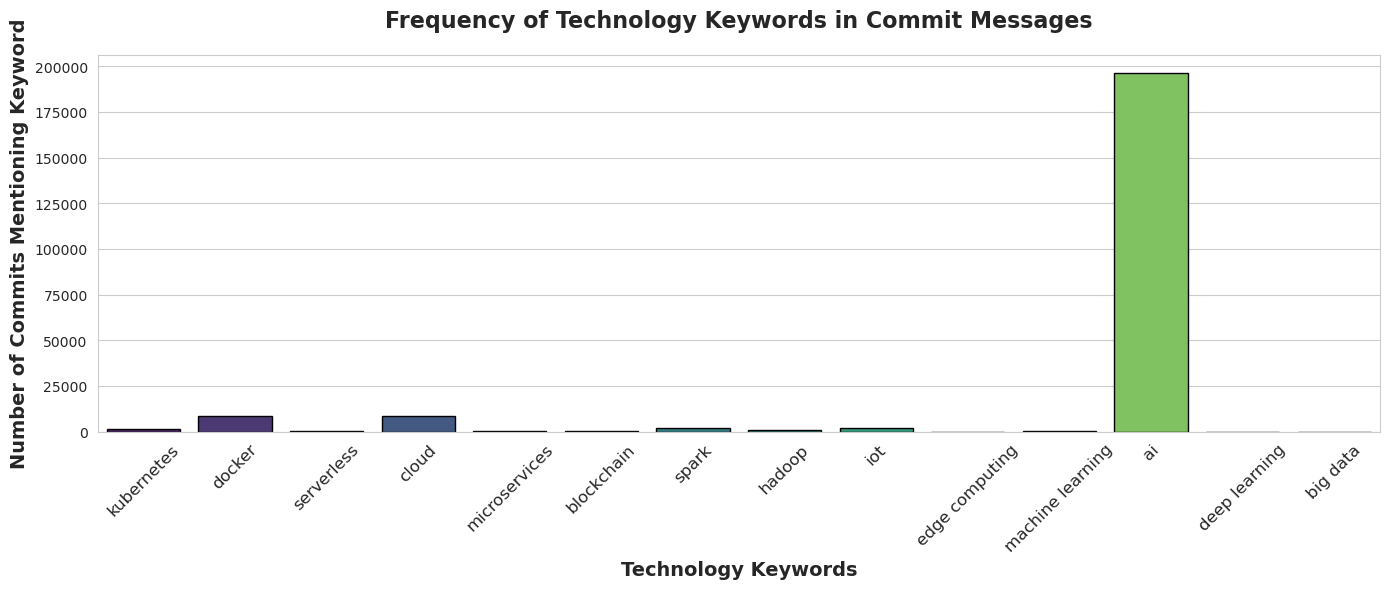

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


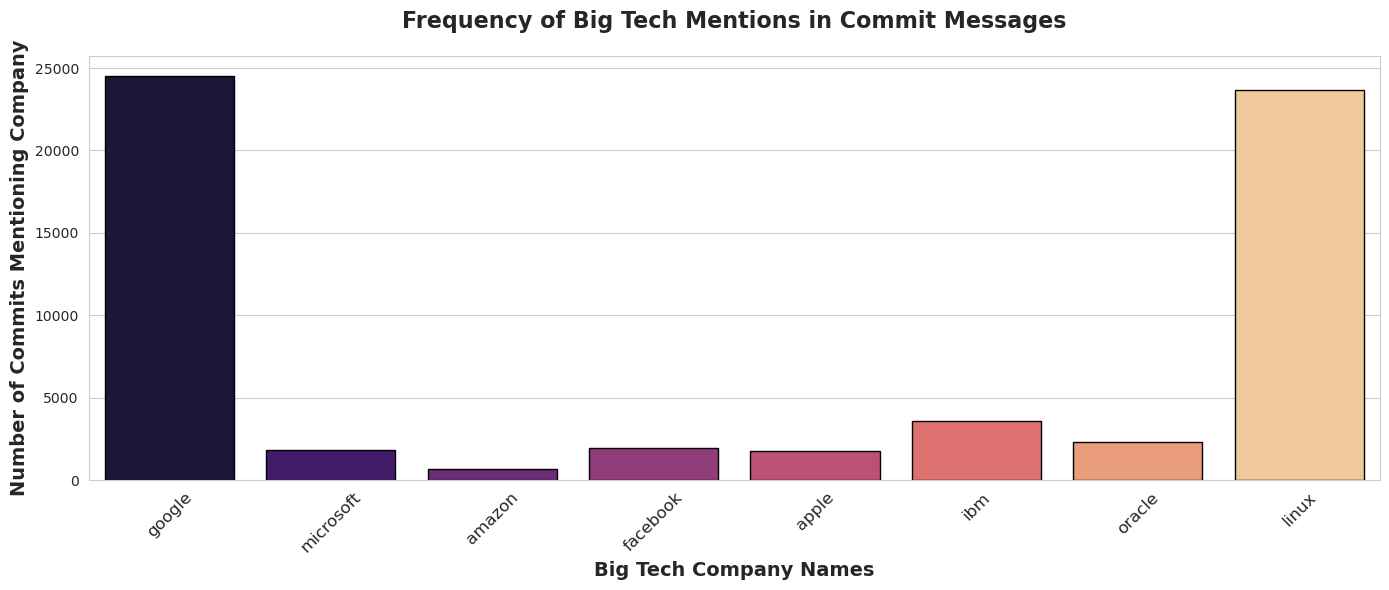

In [24]:
# Define lists of keywords

big_tech_keywords = ["google", "microsoft", "amazon", "facebook", "apple", "ibm", "oracle", "linux"]

tech_keywords = ["kubernetes", "docker", "serverless", "cloud", "microservices", 
                 "blockchain", "spark", "hadoop", "iot", "edge computing", 
                 "machine learning", "ai", "deep learning", "big data"]

# Create a new column with lower-case commit messages for case-insensitive matching
df_lower = df_commits_cleaned.withColumn("message_lower", lower(col("message")))

# Count occurrences of each technology keyword in commit messages
tech_counts = {kw: df_lower.filter(col("message_lower").contains(kw)).count() for kw in tech_keywords}
bigtech_counts = {kw: df_lower.filter(col("message_lower").contains(kw)).count() for kw in big_tech_keywords}

# Print keyword counts
print("Technology Keyword Counts in Commit Messages:")
for kw, cnt in tech_counts.items():
    print(f"{kw}: {cnt}")

print("\nBig Tech Keyword Counts in Commit Messages:")
for kw, cnt in bigtech_counts.items():
    print(f"{kw}: {cnt}")

# Plot technology keyword frequencies
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
sns.barplot(x=list(tech_counts.keys()), y=list(tech_counts.values()), palette="viridis", edgecolor="black")
plt.xlabel("Technology Keywords", fontsize=14, fontweight="bold")
plt.ylabel("Number of Commits Mentioning Keyword", fontsize=14, fontweight="bold")
plt.title("Frequency of Technology Keywords in Commit Messages", fontsize=16, pad=20, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# Plot Big Tech keyword frequencies
plt.figure(figsize=(14, 6))
sns.barplot(x=list(bigtech_counts.keys()), y=list(bigtech_counts.values()), palette="magma", edgecolor="black")
plt.xlabel("Big Tech Company Names", fontsize=14, fontweight="bold")
plt.ylabel("Number of Commits Mentioning Company", fontsize=14, fontweight="bold")
plt.title("Frequency of Big Tech Mentions in Commit Messages", fontsize=16, pad=20, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

### Analyzing DS/AI projects mentions in commit messages

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Data Science/AI Keyword Counts in Commit Messages:
deep learning: 17
pandas: 348
nlp: 312
keras: 181
scikit-learn: 48
artificial intelligence: 6
jupyter: 305
tensorflow: 534
pytorch: 147
computer vision: 3
machine learning: 50
numpy: 748
data science: 16


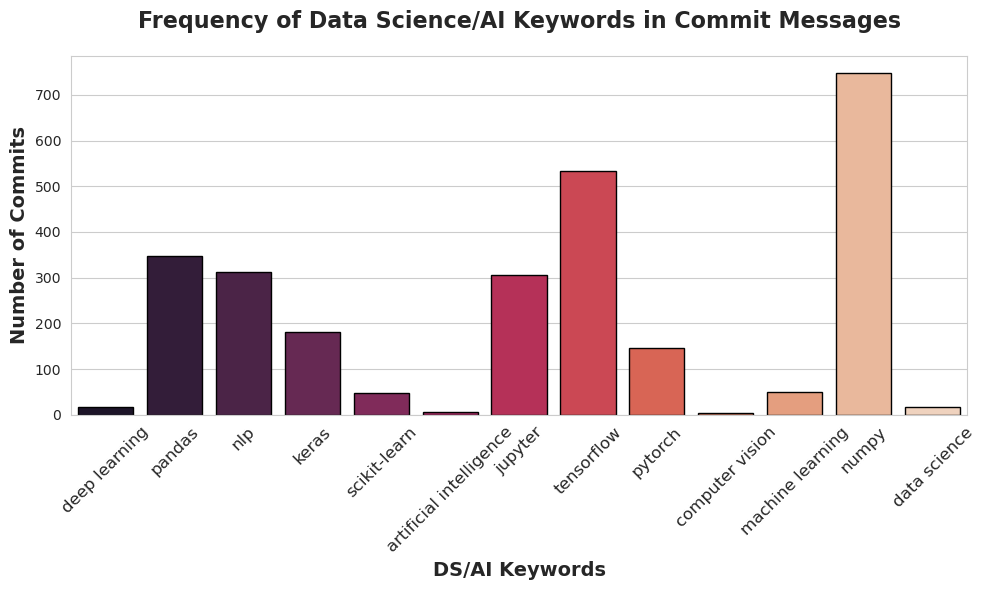

In [25]:
# Define DS/AI keywords
ds_ai_keywords = [
    "deep learning", "pandas", "nlp", "keras", "scikit-learn",
    "artificial intelligence", "jupyter", "tensorflow", "pytorch",
    "computer vision", "machine learning", "numpy", "data science"
]

# Create a lower-case version of commit messages for case-insensitive matching
df_lower = df_commits_cleaned.withColumn("message_lower", lower(col("message")))

# Count occurrences of each DS/AI keyword in commit messages
ds_ai_counts = {kw: df_lower.filter(col("message_lower").contains(kw)).count() for kw in ds_ai_keywords}

# Print keyword counts
print("Data Science/AI Keyword Counts in Commit Messages:")
for kw, cnt in ds_ai_counts.items():
    print(f"{kw}: {cnt}")

# Plot DS/AI keyword frequencies
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(ds_ai_counts.keys()), y=list(ds_ai_counts.values()), palette="rocket", edgecolor="black")
plt.xlabel("DS/AI Keywords", fontsize=14, fontweight="bold")
plt.ylabel("Number of Commits", fontsize=14, fontweight="bold")
plt.title("Frequency of Data Science/AI Keywords in Commit Messages", fontsize=16, pad=20, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

### Trend Analysis of DS/AI projects mentions in commit messages over time 

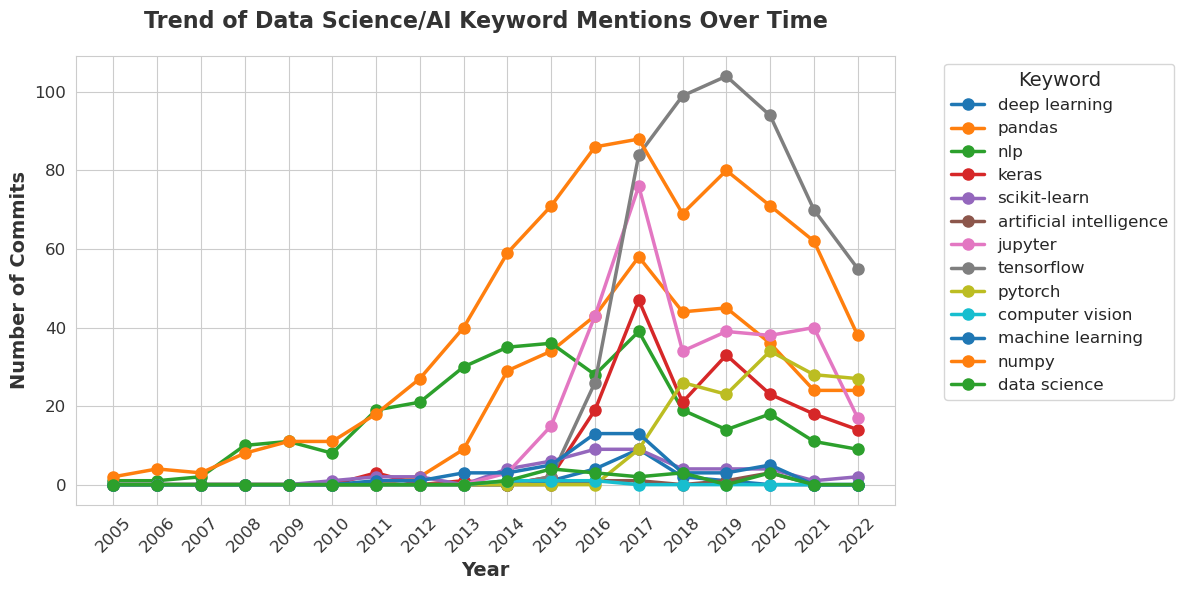

In [26]:
# Initialize list to store trend DataFrames
dfs_trend = [
    df_lower.filter(col("message_lower").contains(kw))
            .withColumn("year", col("author_time").substr(1, 4))
            .groupBy("year").count()
            .withColumnRenamed("count", f"{kw}_trend")
    for kw in ds_ai_keywords
]

# Outer join all keyword DataFrames on "year"
def join_dfs(df1, df2):
    return df1.join(df2, on="year", how="outer")

trend_joined = reduce(join_dfs, dfs_trend).fillna(0).orderBy("year")

# Convert to Pandas and sort by year
trend_pd = trend_joined.toPandas().sort_values("year")

# Plot trends with a modern design
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
for kw in ds_ai_keywords:
    plt.plot(trend_pd["year"], trend_pd[f"{kw}_trend"], marker="o", markersize=8, linewidth=2.5, label=kw)

# Add title, labels, and legend
plt.title("Trend of Data Science/AI Keyword Mentions Over Time", fontsize=16, pad=20, fontweight="bold", color="#333333")
plt.xlabel("Year", fontsize=14, fontweight="bold", color="#333333")
plt.ylabel("Number of Commits", fontsize=14, fontweight="bold", color="#333333")
plt.legend(title="Keyword", title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, fontsize=12, color="#333333")
plt.yticks(fontsize=12, color="#333333")
plt.tight_layout()

# Show the plot
plt.show()

### Analyzing reasons to commit in messages

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Frequent Commit Reason Keyword Counts:
refactor: 33697
add: 481964
improve: 34585
fix: 399366
merge: 276049
remove: 127323
documentation: 20622
release: 51312
bug fix: 7751
update: 360741
feature: 28538
testing: 14593


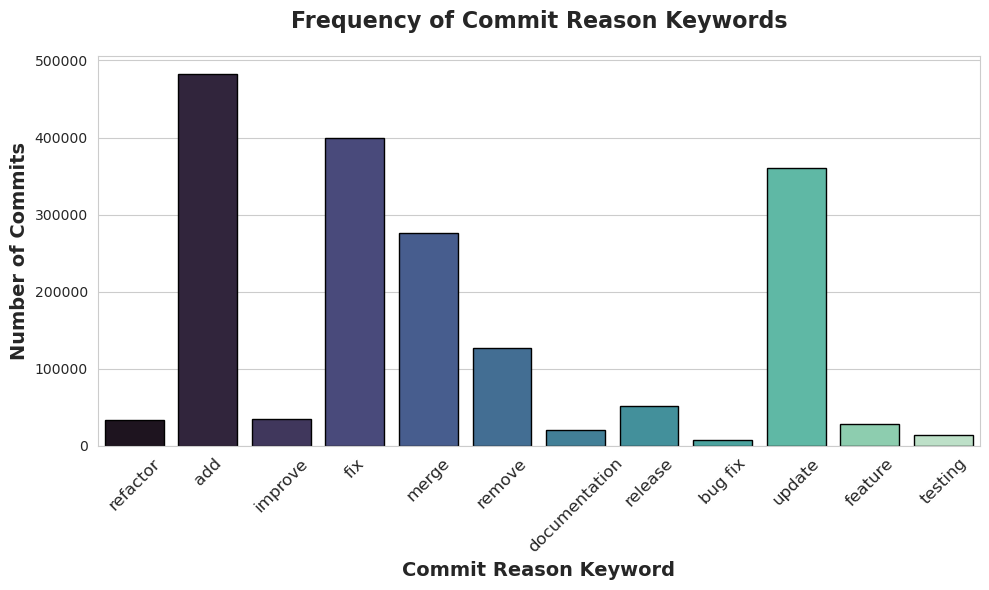

In [24]:
# Define a list of common commit reason keywords
commit_reason_keywords = ["refactor", "add", "improve", "fix", "merge", "remove", "documentation",
                          "release", "bug fix", "update", "feature", "testing"]

# Create a new column with lower-case commit messages for case-insensitive matching
df_lowercase_msgs = df_commits_cleaned.withColumn("message_lower", lower(col("message")))

# Count occurrences of each keyword in commit messages
keyword_frequencies = {kw: df_lowercase_msgs.filter(col("message_lower").contains(kw)).count() for kw in commit_reason_keywords}

# Print keyword counts
print("Frequent Commit Reason Keyword Counts:")
for kw, cnt in keyword_frequencies.items():
    print(f"{kw}: {cnt}")

# Plot the frequency counts
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(keyword_frequencies.keys()), y=list(keyword_frequencies.values()), palette="mako", edgecolor="black")
plt.xlabel("Commit Reason Keyword", fontsize=14, fontweight="bold")
plt.ylabel("Number of Commits", fontsize=14, fontweight="bold")
plt.title("Frequency of Commit Reason Keywords", fontsize=16, pad=20, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

### Analyzing top 3 tech related mentions in commit messages

Top Technologies by Peak YoY Growth:
docker: 4800.00%
big data: 1000.00%
spark: 534.62%
cloud: 500.00%
kubernetes: 350.00%


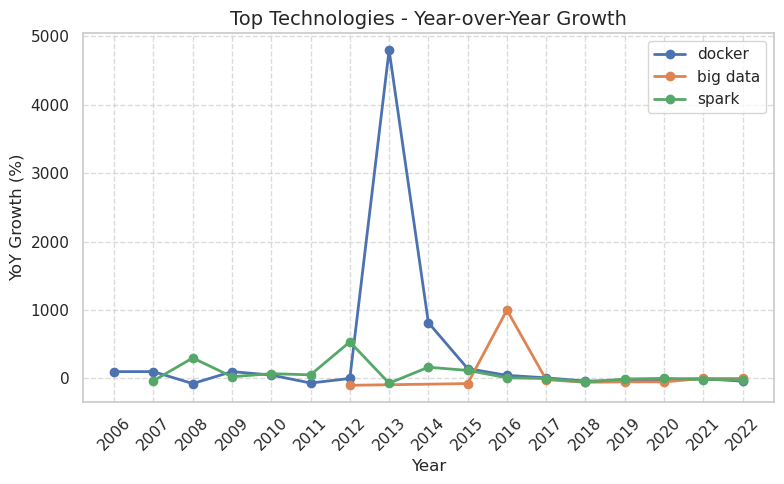

In [44]:
# Define technology-related keywords
tech_keywords = [
    "deep learning", "cloud", "iot", "machine learning", "docker",
    "big data", "microservices", "artificial intelligence", "LLM", "ChatGPT",
    "kubernetes", "serverless", "blockchain", "spark", "hadoop", "edge computing", "ai"
]

# Convert commit messages to lowercase
df_lower = df_commits_cleaned.withColumn("message_lower", lower(col("message")))

# Count keyword occurrences per year
def keyword_count_df(keyword):
    return (
        df_lower.filter(col("message_lower").contains(keyword))
        .withColumn("year", col("author_time").substr(1, 4))
        .groupBy("year").count()
        .withColumnRenamed("count", f"{keyword}_count")
    )

# Generate list of keyword DataFrames
keyword_dfs = list(map(keyword_count_df, tech_keywords))

# Merge all keyword DataFrames on "year" if list is not empty
if keyword_dfs:
    joined_years_df = reduce(lambda df1, df2: df1.join(df2, "year", "outer"), keyword_dfs).fillna(0).orderBy("year")
else:
    joined_years_df = None

# Convert to Pandas DataFrame if not empty
if joined_years_df:
    joined_pd = joined_years_df.toPandas().sort_values(by="year")
else:
    joined_pd = pd.DataFrame()

# Compute year-over-year (YoY) growth
def compute_yoy_growth(df, col_name):
    return [(df["year"][i], ((df[col_name][i] - df[col_name][i-1]) / df[col_name][i-1] * 100) if df[col_name][i-1] > 0 else None)
            for i in range(1, len(df))]

# Find technologies with highest YoY growth
max_growth_info = []
if not joined_pd.empty:
    for keyword in tech_keywords:
        col_name = f"{keyword}_count"
        if col_name in joined_pd.columns:
            growth_rates = compute_yoy_growth(joined_pd, col_name)
            valid_rates = [rate for _, rate in growth_rates if rate is not None]
            if valid_rates:
                max_growth_info.append((keyword, max(valid_rates)))

max_growth_info.sort(key=lambda x: x[1], reverse=True)

# Display top technologies by growth
print("Top Technologies by Peak YoY Growth:")
for tech, rate in max_growth_info[:5]:
    print(f"{tech}: {rate:.2f}%")

# Plot top 3 technologies' YoY growth
if max_growth_info:
    plt.figure(figsize=(8, 5))
    top_tech = [x[0] for x in max_growth_info[:3]]
    for tech in top_tech:
        col_name = f"{tech}_count"
        yoy_data = compute_yoy_growth(joined_pd, col_name)
        yoy_years, yoy_rates = zip(*[(y, r) for y, r in yoy_data if r is not None])
        plt.plot(yoy_years, yoy_rates, marker='o', linestyle='-', linewidth=2, label=tech)

    plt.xlabel("Year", fontsize=12)
    plt.ylabel("YoY Growth (%)", fontsize=12)
    plt.title("Top Technologies - Year-over-Year Growth", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Analyzing top 3 tech breakthoughs mentions in commit messages

In [ ]:
# Define potential "breakthrough" keywords
breakthrough_keywords = [
    "tensorflow", "quantum", "self-driving", "gpt", "llm", "dalle",
    "stable diffusion", "chatgpt", "pytorch", "cuda", "transformer", "cloud"
]

# Create a lower-case version of commit messages for case-insensitive matching
df_lower_msgs = df_commits_cleaned.withColumn("message_lower", lower(col("message")))

# Helper function: group by year and count commits containing a specific keyword
def group_by_year(df, keyword):
    return (df.filter(col("message_lower").contains(keyword))
              .withColumn("year", col("author_time").substr(1, 4))
              .groupBy("year").count()
              .withColumnRenamed("count", f"{keyword}_count"))

# Create a list of DataFrames, each containing year + commit counts for a keyword
keyword_year_dfs = [group_by_year(df_lower_msgs, kw) for kw in breakthrough_keywords]

# Outer join all DataFrames on "year"
joined_years = reduce(lambda df1, df2: df1.join(df2, on="year", how="outer"), keyword_year_dfs).fillna(0).orderBy("year")

# Convert to Pandas and sort by year
joined_pd = joined_years.toPandas().sort_values("year")

# Function to compute year-over-year (YoY) growth rates
def compute_yoy_growth(df, keyword_col):
    years = df["year"].tolist()
    counts = df[keyword_col].tolist()
    return [(years[i], ((counts[i] - counts[i - 1]) / counts[i - 1] * 100)) for i in range(1, len(counts)) if counts[i - 1] > 0]

# Identify highest growth rates among the breakthrough keywords
max_growth_info = []
for kw in breakthrough_keywords:
    col_name = f"{kw}_count"
    if col_name in joined_pd.columns:
        yoy_rates = compute_yoy_growth(joined_pd, col_name)
        if yoy_rates:
            peak_rate = max(rate for (_, rate) in yoy_rates)
            max_growth_info.append((kw, peak_rate))

# Sort by peak YoY growth (descending)
max_growth_info.sort(key=lambda x: x[1], reverse=True)

# Print top breakthroughs by peak YoY growth
print("=== Potential Breakthrough Keywords with Highest YoY Growth ===")
for tech, rate in max_growth_info:
    print(f"{tech}: {rate:.2f}% peak growth")

# Plot YoY growth for top 3 breakthroughs
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
for tech, _ in max_growth_info[:3]:
    col_name = f"{tech}_count"
    yoy_data = compute_yoy_growth(joined_pd, col_name)
    yoy_years = [yr for (yr, _) in yoy_data]
    yoy_rates = [rate for (_, rate) in yoy_data]
    plt.plot(yoy_years, yoy_rates, marker="o", markersize=8, linewidth=2.5, label=tech)

# Add title, labels, and legend
plt.title("Year-over-Year Growth Rates for Potential Breakthroughs", fontsize=16, pad=20, fontweight="bold", color="#333333")
plt.xlabel("Year", fontsize=14, fontweight="bold", color="#333333")
plt.ylabel("Year-over-Year Growth (%)", fontsize=14, fontweight="bold", color="#333333")
plt.legend(title="Technology", title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, fontsize=12, color="#333333")
plt.yticks(fontsize=12, color="#333333")
plt.tight_layout()

# Show the plot
plt.show()

## Join Language data

In [28]:
df_languages = spark.read.parquet(os.path.join(gcs_folder, 'languages'))

print(f'Records read from dataframe *languages*: {df_languages.count():,.0f}')

sample_df_languages = df_languages.sample(fraction = 0.01, seed = 42)

exploded_df_langs = sample_df_languages.withColumn("languages", explode("language"))

flattened_df_langs = exploded_df_langs.select(
    "repo_name",
    col("languages.name").alias("language"),
    col("languages.bytes").alias("bytes")
)

license_lang_df = df_commits_cleaned.join(sample_df_licenses, on="repo_name", how="inner") \
                     .join(flattened_df_langs, on="repo_name", how="inner")

Records read from dataframe *languages*: 3,325,634


In [32]:
# Group by license and language, count repositories
license_lang_counts = license_lang_df.groupBy("license", "language") \
                               .agg(count("repo_name").alias("repo_count")) \
                               .orderBy("repo_count", ascending=False)

# Convert to Pandas DataFrame
license_lang_counts_pd = license_lang_counts.toPandas()

# Show top associations
print(license_lang_counts_pd.head())

      license    language  repo_count
0  apache-2.0  JavaScript          53
1  apache-2.0        HTML          53
2     gpl-3.0       Shell          52
3     gpl-3.0         CSS          51
4     gpl-3.0  JavaScript          51


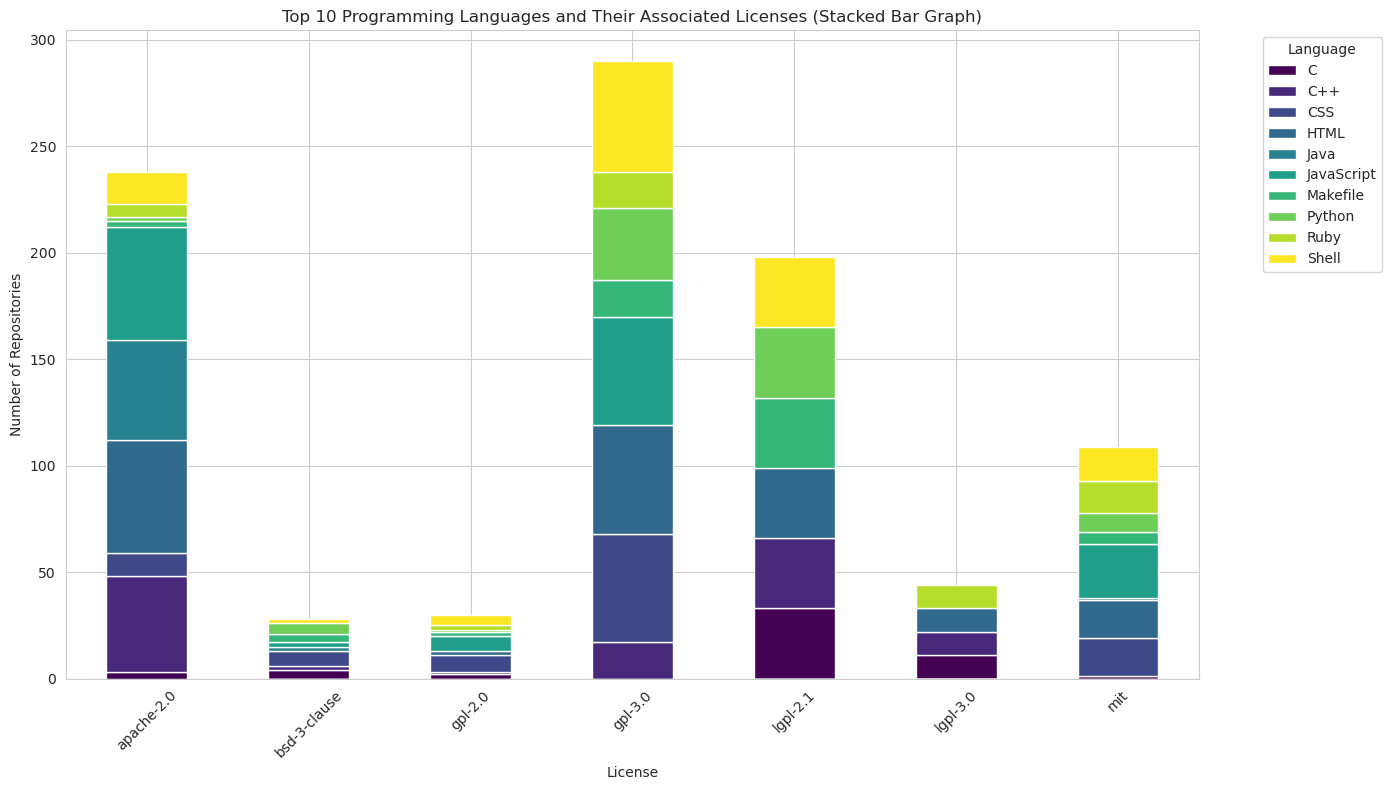

In [31]:
# Filter the top 10 languages by repo_count
top_languages = license_lang_counts_pd.groupby("language")["repo_count"].sum().nlargest(10).index
filtered_data = license_lang_counts_pd[license_lang_counts_pd["language"].isin(top_languages)]

# Pivot the filtered data to create a stacked bar chart
pivot_df = filtered_data.pivot(index="license", columns="language", values="repo_count")

# Plot the stacked bar graph
pivot_df.plot(kind="bar", stacked=True, figsize=(14, 8), colormap="viridis")

# Add labels and title
plt.xlabel("License")
plt.ylabel("Number of Repositories")
plt.title("Top 10 Programming Languages and Their Associated Licenses (Stacked Bar Graph)")
plt.xticks(rotation=45)
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Duplication Analysis 

<Figure size 1000x600 with 0 Axes>

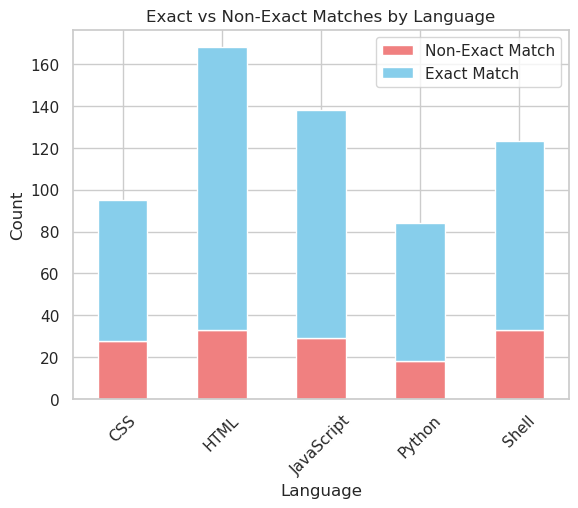

In [40]:
# Filter for top 5 languages
top5_languages = ["CSS", "HTML", "JavaScript", "Python", "Shell"]
commits_top_languages_df = license_lang_df.filter(col("language").isin(top5_languages))

# Tokenize subject and message
tokenizer_subject = Tokenizer(inputCol="subject", outputCol="subject_tokens")
tokenized_subject_df = tokenizer_subject.transform(commits_top_languages_df)

tokenizer_message = Tokenizer(inputCol="message", outputCol="message_tokens")
tokenized_message_df = tokenizer_message.transform(tokenized_subject_df)

# HashingTF for subject and message
hashing_subject = HashingTF(inputCol="subject_tokens", outputCol="subject_features", numFeatures=100)
hashed_subject_df = hashing_subject.transform(tokenized_message_df)

hashing_message = HashingTF(inputCol="message_tokens", outputCol="message_features", numFeatures=100)
hashed_message_df = hashing_message.transform(hashed_subject_df)

# Define cosine similarity function
def cosine_similarity(subject_vector, message_vector):
    subject_array = subject_vector.toArray()
    message_array = message_vector.toArray()
    dot_product = np.dot(subject_array, message_array)
    norm_subject = np.linalg.norm(subject_array)
    norm_message = np.linalg.norm(message_array)
    if norm_subject == 0 or norm_message == 0:
        return 0.0
    return float(dot_product / (norm_subject * norm_message))

cosine_similarity_udf = udf(cosine_similarity, DoubleType())

# Calculate cosine similarity
similarity_df = hashed_message_df.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("subject_features"), col("message_features"))
)

# Round similarity and determine exact matches
rounded_similarity_df = similarity_df.withColumn(
    "cosine_similarity_rounded",
    round(col("cosine_similarity"), 2)
)

exact_match_df = rounded_similarity_df.withColumn(
    "is_exact_match",
    when(col("cosine_similarity_rounded") == 1.0, True).otherwise(False)
)

# Group by language and exact match, then count
exact_match_counts_df = exact_match_df.groupBy("language", "is_exact_match").count()

# Convert to Pandas for visualization
exact_match_counts_pd = exact_match_counts_df.toPandas()

# Pivot the data for visualization
pivot_df = exact_match_counts_pd.pivot(
    index="language", 
    columns="is_exact_match", 
    values="count"
)

# Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
pivot_df.plot(kind="bar", stacked=True, color=["lightcoral", "skyblue"])
plt.title("Exact vs Non-Exact Matches by Language")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(["Non-Exact Match", "Exact Match"], loc="upper right")
plt.show()

<Figure size 1000x600 with 0 Axes>

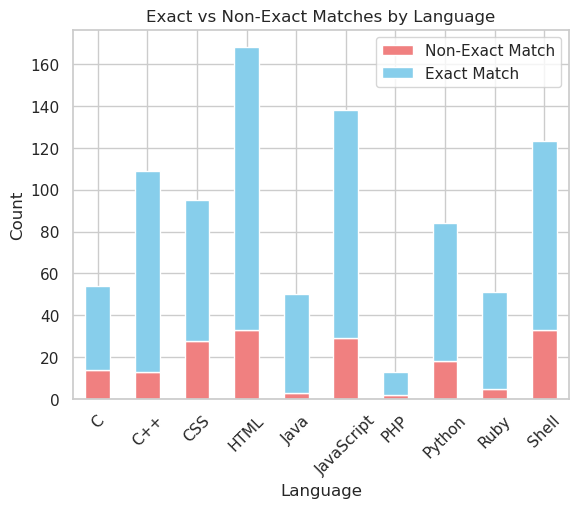

In [43]:
# Filter for top 10 languages
top10_languages = ["C", "CSS", "C++", "HTML", "Java",
                   "JavaScript", "PHP", "Python", "Ruby", "Shell"]
commits_top_languages_df = license_lang_df.filter(col("language").isin(top10_languages))

# Tokenize subject and message
tokenizer_subject = Tokenizer(inputCol="subject", outputCol="subject_tokens")
tokenized_subject_df = tokenizer_subject.transform(commits_top_languages_df)

tokenizer_message = Tokenizer(inputCol="message", outputCol="message_tokens")
tokenized_message_df = tokenizer_message.transform(tokenized_subject_df)

# HashingTF for subject and message
hashing_subject = HashingTF(inputCol="subject_tokens", outputCol="subject_features", numFeatures=100)
hashed_subject_df = hashing_subject.transform(tokenized_message_df)

hashing_message = HashingTF(inputCol="message_tokens", outputCol="message_features", numFeatures=100)
hashed_message_df = hashing_message.transform(hashed_subject_df)

# Define cosine similarity function
def cosine_similarity(subject_vector, message_vector):
    subject_array = subject_vector.toArray()
    message_array = message_vector.toArray()
    dot_product = np.dot(subject_array, message_array)
    norm_subject = np.linalg.norm(subject_array)
    norm_message = np.linalg.norm(message_array)
    if norm_subject == 0 or norm_message == 0:
        return 0.0
    return float(dot_product / (norm_subject * norm_message))

cosine_similarity_udf = udf(cosine_similarity, DoubleType())

# Calculate cosine similarity
similarity_df = hashed_message_df.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("subject_features"), col("message_features"))
)

# Round similarity and determine exact matches
rounded_similarity_df = similarity_df.withColumn(
    "cosine_similarity_rounded",
    round(col("cosine_similarity"), 2)
)

exact_match_df = rounded_similarity_df.withColumn(
    "is_exact_match",
    when(col("cosine_similarity_rounded") == 1.0, True).otherwise(False)
)

# Group by language and exact match, then count
exact_match_counts_df = exact_match_df.groupBy("language", "is_exact_match").count()

# Convert to Pandas for visualization
exact_match_counts_pd = exact_match_counts_df.toPandas()

# Pivot the data for visualization
pivot_df = exact_match_counts_pd.pivot(
    index="language", 
    columns="is_exact_match", 
    values="count"
)

# Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
pivot_df.plot(kind="bar", stacked=True, color=["lightcoral", "skyblue"])
plt.title("Exact vs Non-Exact Matches by Language")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(["Non-Exact Match", "Exact Match"], loc="upper right")
plt.show()